In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set(style="white")


from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import train_test_split,KFold,GridSearchCV,cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,precision_recall_curve,roc_curve, precision_score,recall_score,f1_score
from sklearn.tree import DecisionTreeClassifier

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data = pd.read_excel('/content/BreastCancer_Prognostic_v1.xlsx',header=0)
print(data.shape)
# 'Lymph_Node_Status' has undefined values
data.head()

(198, 35)


,ID,Outcome,Time,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,radius_std_dev,texture_std_dev,perimeter_std_dev,area_std_dev,smoothness_std_dev,compactness_std_dev,concavity_std_dev,concave_points_std_dev,symmetry_std_dev,fractal_dimension_std_dev,Worst_radius,Worst_texture,Worst_perimeter,Worst_area,Worst_smoothness,Worst_compactness,Worst_concavity,Worst_concave_points,Worst_symmetry,Worst_fractal_dimension,Tumor_Size,Lymph_Node_Status
0,119513,N,31,18.02,27.60,117.50,1013.0,0.09489,0.1036,0.1086,0.07055,0.1865,0.06333,0.6249,1.8900,3.972,71.55,0.004433,0.01421,0.03233,0.009854,0.01694,0.003495,21.63,37.08,139.70,1436.0,0.1195,0.1926,0.3140,0.1170,0.2677,0.08113,5.0,5
1,8423,N,61,17.99,10.38,122.80,1001.0,0.11840,0.2776,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.015870,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,3.0,2
2,842517,N,116,21.37,17.44,137.50,1373.0,0.08836,0.1189,0.1255,0.08180,0.2333,0.06010,0.5854,0.6105,3.928,82.15,0.006167,0.03449,0.03300,0.018050,0.03094,0.005039,24.90,20.98,159.10,1949.0,0.1188,0.3449,0.3414,0.2032,0.4334,0.09067,2.5,0
3,843483,N,123,11.42,20.38,77.58,386.1,0.14250,0.2839,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.018670,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,2.0,0
4,843584,R,27,20.29,14.34,135.10,1297.0,0.10030,0.1328,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.018850,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,3.5,0


In [3]:
data = data.replace('?', np.nan)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         198 non-null    int64  
 1   Outcome                    198 non-null    object 
 2   Time                       198 non-null    int64  
 3   radius_mean                198 non-null    float64
 4   texture_mean               198 non-null    float64
 5   perimeter_mean             198 non-null    float64
 6   area_mean                  198 non-null    float64
 7   smoothness_mean            198 non-null    float64
 8   compactness_mean           198 non-null    float64
 9   concavity_mean             198 non-null    float64
 10  concave_points_mean        198 non-null    float64
 11  symmetry_mean              198 non-null    float64
 12  fractal_dimension_mean     198 non-null    float64
 13  radius_std_dev             198 non-null    float64

In [4]:
data=data.dropna(how='any')
data['Lymph_Node_Status']= data['Lymph_Node_Status'].astype(float)
measurements= data.columns[3:35]
measurements

Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_std_dev', 'texture_std_dev', 'perimeter_std_dev',
       'area_std_dev', 'smoothness_std_dev', 'compactness_std_dev',
       'concavity_std_dev', 'concave_points_std_dev', 'symmetry_std_dev',
       'fractal_dimension_std_dev', 'Worst_radius', 'Worst_texture',
       'Worst_perimeter', 'Worst_area', 'Worst_smoothness',
       'Worst_compactness', 'Worst_concavity', 'Worst_concave_points',
       'Worst_symmetry', 'Worst_fractal_dimension', 'Tumor_Size',
       'Lymph_Node_Status'],
      dtype='object')

In [5]:
print('total_mean --',data['perimeter_mean'].mean())
print('total_median -- ', data['perimeter_mean'].median())
print('total_standard deviation -- ',data['perimeter_mean'].std())

print('Non_recurrent_mean --',data.loc[data['Outcome']=='N','perimeter_mean'].mean())
print('Non_recurrent_median -- ', data.loc[data['Outcome']=='N','perimeter_mean'].median())
print('Non_recurrent_standard deviation -- ',data.loc[data['Outcome']=='N','perimeter_mean'].std())

print('Recurrent_mean --',data.loc[data['Outcome']=='R','perimeter_mean'].mean())
print('Recurrent_median -- ',data.loc[data['Outcome']=='R','perimeter_mean'].median())
print('Recurrent_standard deviation -- ',data.loc[data['Outcome']=='R','perimeter_mean'].std())

total_mean -- 114.78149484536077
total_median --  113.7
total_standard deviation --  21.43069367595496
Non_recurrent_mean -- 112.81912162162162
Non_recurrent_median --  110.25
Non_recurrent_standard deviation --  20.638927123972433
Recurrent_mean -- 121.09521739130437
Recurrent_median --  123.55000000000001
Recurrent_standard deviation --  22.91019479417943


In [0]:

X_train, X_test, y_train, y_test = train_test_split(data[measurements],data['Outcome'],test_size = 0.2 ,random_state=42)

In [7]:
X_train.shape

(155, 32)

In [8]:
X_test.shape

(39, 32)

In [9]:
X_train.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,radius_std_dev,texture_std_dev,perimeter_std_dev,area_std_dev,smoothness_std_dev,compactness_std_dev,concavity_std_dev,concave_points_std_dev,symmetry_std_dev,fractal_dimension_std_dev,Worst_radius,Worst_texture,Worst_perimeter,Worst_area,Worst_smoothness,Worst_compactness,Worst_concavity,Worst_concave_points,Worst_symmetry,Worst_fractal_dimension,Tumor_Size,Lymph_Node_Status
count,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000
mean,17.157613,22.412452,113.228452,941.296129,0.103416,0.143729,0.155732,0.085718,0.193001,0.063026,0.586881,1.295188,4.158194,66.611806,0.006973,0.031822,0.041233,0.015146,0.020656,0.004045,20.617355,30.330774,137.796516,1348.287097,0.145436,0.369447,0.439724,0.177117,0.323474,0.091495,2.935484,3.400000
std,3.130416,4.303813,21.215574,339.661731,0.012765,0.051396,0.070969,0.033635,0.026794,0.007463,0.293372,0.545500,2.099462,43.230749,0.003207,0.018689,0.021207,0.005581,0.009410,0.002051,4.023812,6.024674,27.626140,536.331520,0.022788,0.174552,0.181144,0.045670,0.076503,0.022773,2.064944,5.502774
min,10.950000,10.380000,71.900000,361.600000,0.075920,0.046050,0.023980,0.027040,0.130800,0.050250,0.193800,0.362100,1.153000,13.990000,0.002826,0.007347,0.010940,0.005174,0.007882,0.001087,12.840000,16.670000,85.100000,508.100000,0.081910,0.051310,0.023980,0.028990,0.156500,0.055040,0.400000,0.000000
25%,14.820000,19.645000,96.790000,674.750000,0.093940,0.111650,0.104350,0.062060,0.174250,0.056945,0.388700,0.924600,2.781000,34.550000,0.005038,0.019615,0.027700,0.011360,0.014965,0.002742,17.385000,26.375000,116.400000,926.950000,0.131050,0.247900,0.329850,0.151250,0.274350,0.076285,1.500000,0.000000
50%,17.200000,21.900000,112.700000,928.200000,0.102600,0.131900,0.152500,0.084510,0.190700,0.061940,0.529900,1.199000,3.706000,56.180000,0.006356,0.028210,0.035820,0.013920,0.017980,0.003739,20.380000,30.380000,133.500000,1269.000000,0.143100,0.349800,0.402900,0.177200,0.315100,0.087620,2.500000,1.000000
75%,19.540000,25.045000,129.100000,1182.500000,0.112150,0.171750,0.197700,0.101200,0.210100,0.067055,0.696600,1.517000,5.033500,82.020000,0.008077,0.038930,0.049095,0.018110,0.023415,0.004764,23.530000,33.530000,158.350000,1665.000000,0.155950,0.433000,0.532600,0.206950,0.360200,0.102850,3.500000,4.000000
max,25.730000,39.280000,174.200000,2010.000000,0.144700,0.311400,0.426800,0.201200,0.267800,0.097440,1.819000,3.503000,13.280000,253.800000,0.031130,0.135400,0.143800,0.039270,0.059630,0.012560,33.130000,49.540000,229.300000,3432.000000,0.222600,1.058000,1.170000,0.290300,0.663800,0.207500,10.000000,27.000000



we can see that the range of values between each feature vary a lot so we'll need to normalise the featuers when building a predictive model

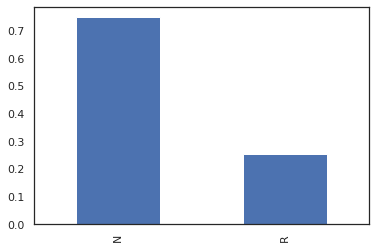

In [10]:
(y_train.value_counts()/y_train.shape[0]).plot(kind='bar')


It looks like a imbalanced dataset. By tracking different metrics we can see whether this affects our models. If yes, we can try to fix this by over/under/synthetic sampling or by modifiying the loss function to penalise the Non recurrent cases more than Recurrent cases

**How does each feature vary for Recurrent vs Non-Recurrent case**

In [11]:

X_train[y_train=='N'].mean() - X_train[y_train=='R'].mean()


radius_mean                   -0.911468
texture_mean                   0.496302
perimeter_mean                -6.062624
area_mean                   -100.731189
smoothness_mean                0.000425
compactness_mean               0.004760
concavity_mean                 0.000504
concave_points_mean           -0.005164
symmetry_mean                  0.004212
fractal_dimension_mean         0.002051
radius_std_dev                -0.046050
texture_std_dev                0.112290
perimeter_std_dev             -0.392586
area_std_dev                  -7.816452
smoothness_std_dev             0.000330
compactness_std_dev           -0.000094
concavity_std_dev              0.003487
concave_points_std_dev         0.000770
symmetry_std_dev              -0.000004
fractal_dimension_std_dev      0.000132
Worst_radius                  -1.488780
Worst_texture                  0.808926
Worst_perimeter               -9.950831
Worst_area                  -184.663904
Worst_smoothness              -0.001000


We can observe that for almost all features the mean value for Non-Recurrent cases are lower than mean value for Recurrent cases

**Feature Correlations**

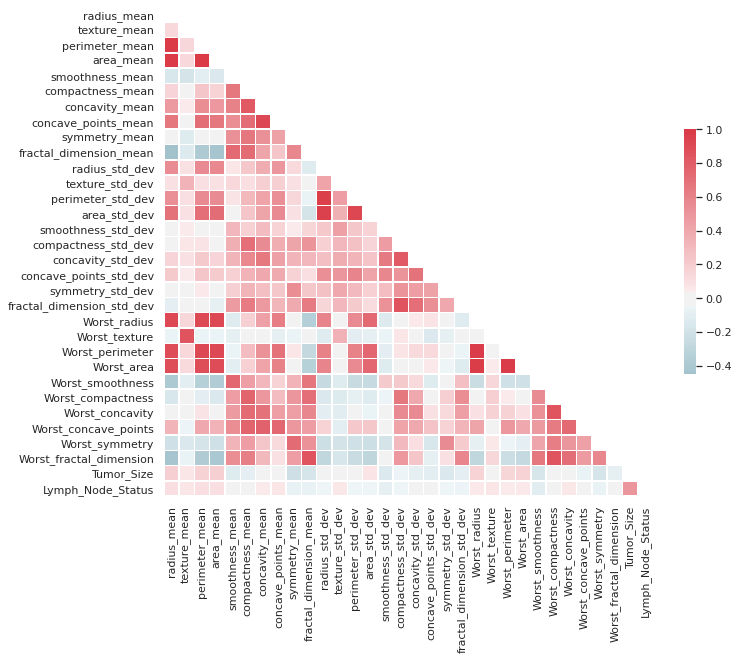

In [12]:

corr = X_train[measurements].corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [0]:
# dropping columns with correlation > 95%
dropped_columns = ['perimeter_mean', 'area_mean', 'Worst_radius','Worst_perimeter','Worst_area', "perimeter_std_dev", "area_std_dev"]
X_train = X_train.drop(dropped_columns, axis=1)
X_test = X_test.drop(dropped_columns, axis=1)


In [0]:
#updating measurements list as we've dropped some columns
measurements= list(measurements)
for col in dropped_columns:
    measurements.remove(col)

**Check which features are discriminative of R and N** 

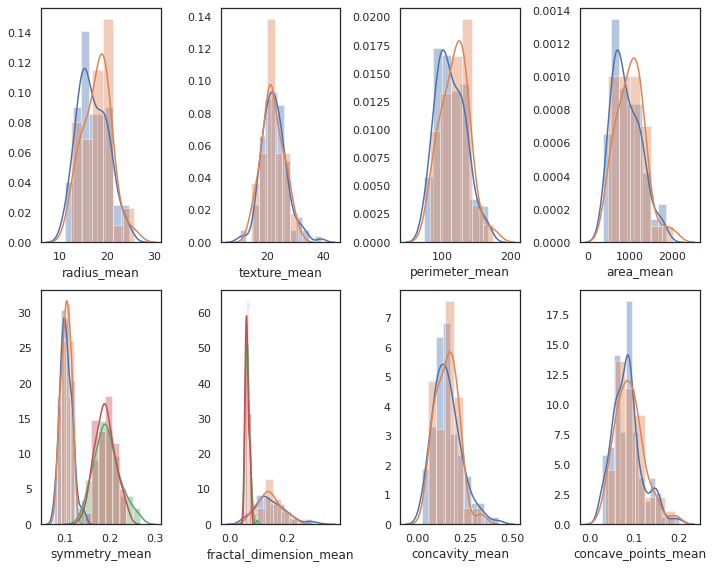

In [14]:
f, axes = plt.subplots(2, 4,figsize=[10,8])
i=0
j=0
for feature in measurements:
    if feature.endswith('mean'):
        sns.distplot(X_train.loc[y_train=='N',feature],ax = axes[i][j%4])
        sns.distplot(X_train.loc[y_train=='R',feature],ax = axes[i][j%4])
        j+=1
        if j==4:
            i+=1
plt.tight_layout()

we can see that smoothness,symmetry, and fractal_dimensions are not very discriminative between R and N. Dropping these features might improve our model performance as we're getting rid of noisy features. 
On the other hand, radius, perimeter, area, concave_points, compactness,concavity are good features that can help our predictive model.
Texture is a borderline case(due to sharp peaks) where it might or might not be useful in combination with other features.
We can even use PCA to select features that explain the most variance.
We can also see that all the distributions are close to a normal distribution.

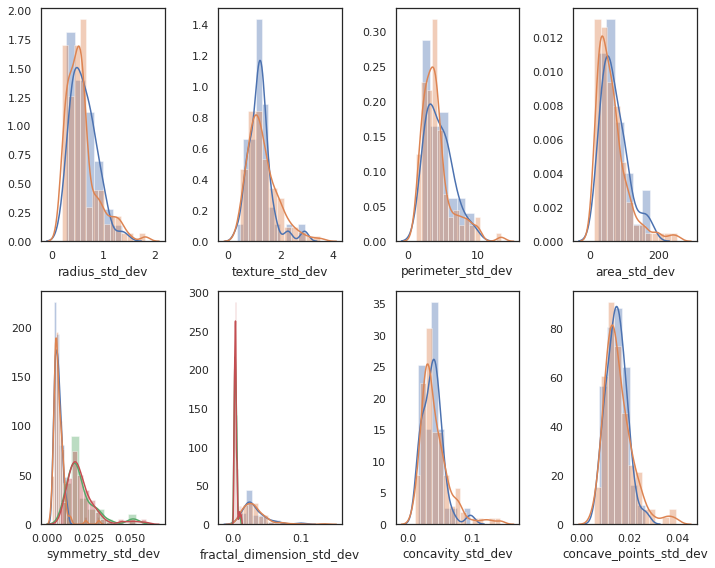

In [15]:
f, axes = plt.subplots(2, 4,figsize=[10,8])
i=0
j=0
for feature in measurements:
    if feature.endswith('std_dev'):
        sns.distplot(X_train.loc[y_train=='R',feature],ax = axes[i][j%4])
        sns.distplot(X_train.loc[y_train=='N',feature],ax = axes[i][j%4])
        j+=1
        if j==4:
            i+=1
plt.tight_layout()

# it's the same story as before but on average mean seems to be a better feature than std_dev

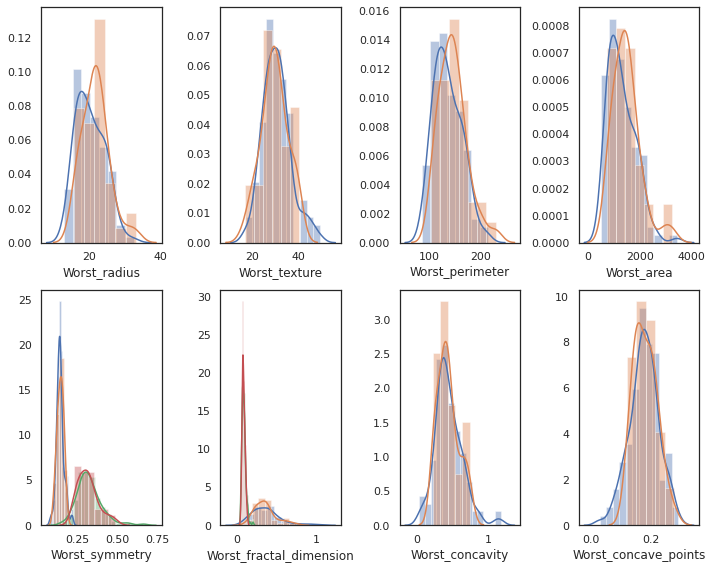

In [16]:
f, axes = plt.subplots(2, 4,figsize=[10,8])
i=0
j=0
for feature in measurements:
    if feature.startswith('Worst'):
        sns.distplot(X_train.loc[y_train=='N',feature],ax = axes[i][j%4])
        sns.distplot(X_train.loc[y_train=='R',feature],ax = axes[i][j%4])
        j+=1
        if j==4:
            i+=1
plt.tight_layout()

# same as the mean plots.

**Scale the features to the same range**

In [0]:

# rs = RobustScaler()
# X_train = rs.fit_transform(X_train)
# X_test = rs.transform(X_test)

In [18]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

y_train = y_train.replace('N',0)
y_train = y_train.replace('R',1)
y_test = y_test.replace('N',0)
y_test = y_test.replace('R',1)
y_train.astype('category')
y_test.astype('category')

141    0
17     1
158    0
99     0
70     0
156    0
57     0
16     0
115    0
114    1
187    0
19     0
84     0
10     0
167    0
120    1
71     0
116    0
194    0
122    0
126    0
147    1
68     0
47     0
161    1
118    0
69     1
96     0
32     0
104    0
121    0
77     0
25     0
175    0
130    0
172    0
20     0
171    0
75     1
Name: Outcome, dtype: category
Categories (2, int64): [0, 1]

In [19]:
# grid search and 5-fold cross validation to choose best model and hyperparameters
svm_params = {'C':[0.005,0.01,1,15,17], 'kernel':['rbf'],'gamma':[0.005,0.01,0.045,0.05],'class_weight' : ['balanced']}
lr_params = {'C':[5,7,10,13,15,18,20,50,100,500],'solver' :['liblinear'],'class_weight' : ['balanced']}
rf_params = {'n_estimators':[10,100,250,500,1000],'class_weight' : ['balanced']}
knn_params = {'n_neighbors':[5,7,10,13,15,18,20]} 
models = []
models.append(('svm',SVC(),svm_params))
models.append(('lr',LogisticRegression(),lr_params))
models.append(('rfc',RandomForestClassifier(),rf_params))
models.append(('knn',KNeighborsClassifier(),knn_params))

for label,model,param in models:
    model_grid = GridSearchCV(model,param,cv=5)
    model_grid.fit(X_train,y_train)
    best_parameters = model_grid.best_params_  
    print(label,best_parameters,model_grid.best_score_,model_grid.cv_results_['std_test_score'][model_grid.best_index_])

svm {'C': 15, 'class_weight': 'balanced', 'gamma': 0.045, 'kernel': 'rbf'} 0.664516129032258 0.07241917522788276
lr {'C': 5, 'class_weight': 'balanced', 'solver': 'liblinear'} 0.5870967741935483 0.08986056953022012
rfc {'class_weight': 'balanced', 'n_estimators': 10} 0.7483870967741936 0.04740947889257759
knn {'n_neighbors': 13} 0.7419354838709677 0.028852490032255325


**Naive Bayes Classifier**

In [20]:
NB = GaussianNB()
NB.fit(X_train, y_train);
NB_pred = NB.predict(X_test)
# Accuracy score
print('NB_Accuracy --- ',accuracy_score(y_test,NB_pred))
# Precision score
print('NB_Precision ---',precision_score(y_test,NB_pred,pos_label=1))
# recall
print('NB_Recall ---',recall_score(y_test,NB_pred,pos_label=1))
# f1_score
print('NB_F1_score ---' , f1_score(y_test,NB_pred,pos_label=1))

# confusion matrix
print('Confusion Matrix ---\n',confusion_matrix(y_test,NB_pred))

NB_Accuracy ---  0.7692307692307693
NB_Precision --- 0.42857142857142855
NB_Recall --- 0.8571428571428571
NB_F1_score --- 0.5714285714285714
Confusion Matrix ---
 [[24  8]
 [ 1  6]]


**Logistic Regression**

In [21]:
lr = LogisticRegression(C=5,class_weight='balanced',solver='liblinear')
lr.fit(X_train,y_train);
lr_pred = lr.predict(X_test)
# Accuracy score
print('LR_Accuracy --- ',accuracy_score(y_test,lr_pred))
# Precision score
print('LR_Precision ---',precision_score(y_test,lr_pred,pos_label=1))
# recall
print('LR_Recall ---',recall_score(y_test,lr_pred,pos_label=1))
# f1_score
print('LR_F1_score ---' , f1_score(y_test,lr_pred,pos_label=1))

# confusion matrix
confusion_matrix(y_test,lr_pred)

LR_Accuracy ---  0.6153846153846154
LR_Precision --- 0.2777777777777778
LR_Recall --- 0.7142857142857143
LR_F1_score --- 0.4


array([[19, 13],
       [ 2,  5]])

**K-Nearest Neighbour Classifier**

In [22]:
knn = KNeighborsClassifier(n_neighbors=13) 
  
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
# Accuracy score
print('KNN_Accuracy --- ',accuracy_score(y_test,knn_pred))
# Precision score
print('KNN_Precision ---',precision_score(y_test,knn_pred,pos_label=1))
# recall
print('KNN_Recall ---',recall_score(y_test,knn_pred,pos_label=1))
# f1_score
print('KNN_F1_score ---' , f1_score(y_test,knn_pred,pos_label=1))

# confusion matrix
print('Confusion Matrix ---\n',confusion_matrix(y_test,knn_pred))
 

KNN_Accuracy ---  0.8205128205128205
KNN_Precision --- 0.5
KNN_Recall --- 0.14285714285714285
KNN_F1_score --- 0.22222222222222224
Confusion Matrix ---
 [[31  1]
 [ 6  1]]


**Random Forest Classifier**


In [23]:
rfc = RandomForestClassifier(n_estimators=500)
rfc.fit(X_train,y_train);
rfc_pred = rfc.predict(X_test)
# Accuracy score
print('RFC_Accuracy --- ',accuracy_score(y_test,rfc_pred))
# Precision score
print('RFC_Precision ---',precision_score(y_test,rfc_pred,pos_label=1))
# recall
print('RFC_Recall ---',recall_score(y_test,rfc_pred,pos_label=1))
# f1_score
print('RFC_F1_score ---' , f1_score(y_test,rfc_pred,pos_label=1))

# confusion matrix
print('Confusion Matrix ---\n',confusion_matrix(y_test,rfc_pred))

RFC_Accuracy ---  0.8205128205128205
RFC_Precision --- 0.0
RFC_Recall --- 0.0
RFC_F1_score --- 0.0
Confusion Matrix ---
 [[32  0]
 [ 7  0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Decision Tree Classifier**

In [24]:
dt = DecisionTreeClassifier(random_state=0)
dt.fit(X_train,y_train);
dt_pred = dt.predict(X_test)
# Accuracy score
print('DT_Accuracy --- ',accuracy_score(y_test,dt_pred))
# Precision score
print('DT_Precision ---',precision_score(y_test,dt_pred,pos_label=1))
# recall
print('DT_Recall ---',recall_score(y_test,dt_pred,pos_label=1))
# f1_score
print('DT_F1_score ---' , f1_score(y_test,dt_pred,pos_label=1))

# confusion matrix
print('Confusion Matrix ---\n',confusion_matrix(y_test,dt_pred))


DT_Accuracy ---  0.6666666666666666
DT_Precision --- 0.2
DT_Recall --- 0.2857142857142857
DT_F1_score --- 0.23529411764705882
Confusion Matrix ---
 [[24  8]
 [ 5  2]]


**Support Vector Machine**

In [25]:
#  svc = SVC(C=17,kernel='rbf',gamma=0.045,class_weight='balanced')
 svc = SVC(C=15,kernel='rbf',gamma=0.045,class_weight='balanced')
svc.fit(X_train,y_train);
svm_pred = svc.predict(X_test)
# Accuracy score
print('SVM_Accuracy --- ',accuracy_score(y_test,svm_pred))
# Precision score
print('SVM_Precision ---',precision_score(y_test,svm_pred,pos_label=1))
# recall
print('SVM_Recall ---',recall_score(y_test,svm_pred,pos_label=1))
# f1_score
print('SVM_F1_score ---' , f1_score(y_test,svm_pred,pos_label=1))

# confusion matrix
confusion_matrix(y_test,svm_pred)

SVM_Accuracy ---  0.8461538461538461
SVM_Precision --- 0.5454545454545454
SVM_Recall --- 0.8571428571428571
SVM_F1_score --- 0.6666666666666665


array([[27,  5],
       [ 1,  6]])

**Best Results shown by SVM classifier**
Accuracy: 84.61%
Recall: 85.71%


In [0]:
prediction = pd.DataFrame()
prediction['Values'] = y_test
prediction['predictions'] = svm_pred
prediction.to_csv('prediction.csv')